## Before running the code:
1. Make sure you read **INSTALL.md**
2. Make sure you change the path to your actual project-path.

In [ ]:
path = r'C:\Users\user\Desktop\SpamDetection_NLP'

In [ ]:
!pip install --upgrade --user pip

In [5]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')

print(sys.version)

3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]


In [ ]:
rootdir = os.getcwd()
%cd $rootdir

### Making sure the required packages are installed

In [8]:
!pip freeze > requirements.txt
!pip install -r requirements.txt;

### Removing previous logs folder

In [ ]:
!rm -r ./logs

# Importing packages

In [10]:
import pickle
import json

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot

from keras_tqdm import TQDMNotebookCallback

import nltk
from nltk.stem.snowball import EnglishStemmer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import keras
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard


import tensorboard

from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


# Basic functions we will use trough this project:
* **acc_loss** enables us to display the accuracy and the loss of the model through every epoch
* **stemmed_words** enables us to stem with english words

In [11]:
def acc_loss(nn_it):
    plt.style.use('ggplot')
    
    acc = nn_it.history['accuracy']
    val_acc = nn_it.history['val_accuracy']
    loss = nn_it.history['loss']
    val_loss = nn_it.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    
def stemmed_words(doc):
    return(stemmer.stem(w) for w in analyzer(doc))

# Pre-process
* The idea is to import the file and make sure the code can adapt if we had different filepath (i.e. differents files)
* We create a Train and Test datasets that we save in order not to run this code multiple times 

## Parameters:

In [12]:
test_size = 0.20

In [13]:
filepath_dict = {'mail': os.path.join(path, r'SMSSpamCollection.txt')}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names = ['label', 'sentence'], sep = '\t')
    df['source'] = source
    df_list.append(df)

# df = pd.concat(df.list) # If you have differents items in filepath_dict
df["label"] = df["label"].map( {"ham":0, "spam":1} ).astype(int)
print(df.iloc[0])

df_mail = df[df['source'] == 'mail']

sentences = df_mail['sentence'].values
y = df_mail['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=test_size, random_state=1337)

sentences_train.shape, sentences_test.shape

with open('pickle/xy.data', 'wb') as f:
    pickle.dump([sentences_train, sentences_test, y_train, y_test], f)

label                                                       0
sentence    Go until jurong point, crazy.. Available only ...
source                                                   mail
Name: 0, dtype: object


# Data Analysis

In [14]:
df.groupby('label').describe()

sentence                                                                 \
         count unique                                                top freq   
label                                                                           
0         4825   4516                             Sorry, I'll call later   30   
1          747    653  Please call our customer service representativ...    4   

      source                     
       count unique   top  freq  
label                            
0       4825      1  mail  4825  
1        747      1  mail   747

### Notes:
* Not all of the messages in our datasets are unique; for example the following message "Please call our customer service representativ..." appears 4 times. 
* This could potentially be a problem because it means that we might not have 747 distinct SPAM messages but far less...

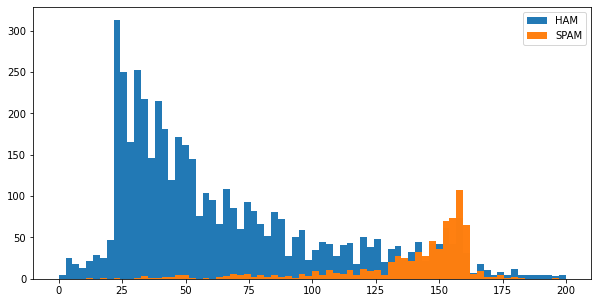

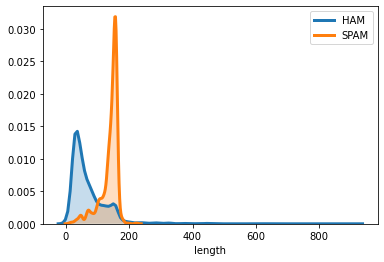

In [15]:
df_analysis = df
df_analysis['length'] = df_analysis['sentence'].apply(len)
df_analysis['nb_words'] = df_analysis['sentence'].str.split(" ").apply(len)
df_analysis_HAM = df_analysis.query("label == 0")
df_analysis_SPAM = df_analysis.query("label == 1")

bins = np.linspace(0, 200, 75)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(1, 1, 1)
pyplot.hist(df_analysis_HAM['length'], bins, alpha=0.99, label='HAM')
pyplot.hist(df_analysis_SPAM['length'], bins, alpha=0.99, label='SPAM')
pyplot.legend(loc='upper right')
pyplot.show()
plt.subplot(1, 1, 1)
sns.distplot(df_analysis_HAM['length'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "HAM")
sns.distplot(df_analysis_SPAM['length'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "SPAM")

fig.tight_layout()
plt.show()

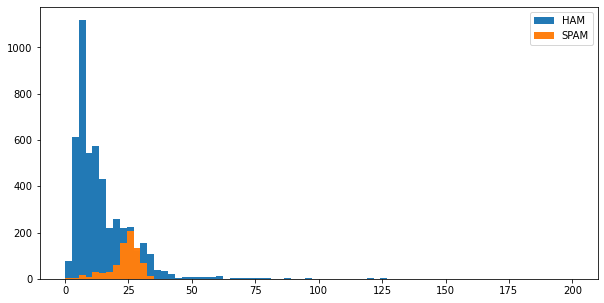

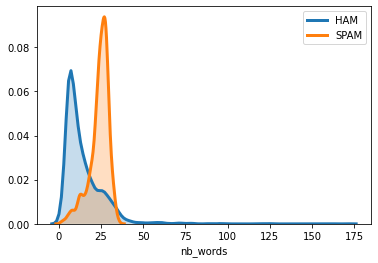

In [16]:
bins = np.linspace(0, 200, 75)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plt.subplot(1, 1, 1)
pyplot.hist(df_analysis_HAM['nb_words'], bins, alpha=0.99, label='HAM')
pyplot.hist(df_analysis_SPAM['nb_words'], bins, alpha=0.99, label='SPAM')
pyplot.legend(loc='upper right')
pyplot.show()

plt.subplot(1, 1, 1)
sns.distplot(df_analysis_HAM['nb_words'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "HAM")
sns.distplot(df_analysis_SPAM['nb_words'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, label = "SPAM")
fig.tight_layout()
plt.show()

In [17]:
print("The number of median words for a HAM message is: {} whereas it is: {} for a SPAM message.".format(np.median(df_analysis_HAM["nb_words"]), np.median(df_analysis_SPAM["nb_words"]) ))
print("The number of median characters for a HAM message is: {} whereas it is: {} for a SPAM message.".format(np.median(df_analysis_HAM["length"]), np.median(df_analysis_SPAM["length"]) ))

The number of median words for a HAM message is: 11.0 whereas it is: 25.0 for a SPAM message.
The number of median characters for a HAM message is: 52.0 whereas it is: 149.0 for a SPAM message.


# Notes:
* Interesting fact: SPAM messages are usually longer (in terms of characters and number of words) than HAM messages.

### Simple Logistic Regression 
* The idea is to see how a common model would perform
* In order to compare to more complex models 

In [18]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer(stop_words = 'english').build_analyzer()

vectorizer = CountVectorizer(analyzer = stemmed_words)
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.979372197309417


In [19]:
stemmer = EnglishStemmer()
analyzer = CountVectorizer().build_analyzer()

vectorizer = CountVectorizer(analyzer = stemmed_words)
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)



classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.9802690582959641


### Notes
* Without removing stopwords we seems to get an higher accuracy 0.9802 > 0.9793

# Bag-Of-Words VS Word Embedding
* **Bag-of-words** and **Word Embedding** refer to different aspects of characterizing a body of text such as a document. They are described well in the textbook "Speech and Language Processing" by Jurafsky and Martin, 2009, in section 23.1 on information retrieval.
* We are going to first build a BoW (Bag-Of-Words) model as we have little data and then try to instantiate a Word Embedding Model


# Bag-Of-Words
* **Bag-of-words**: For a given document, you extract only the unigram words (aka terms) to create an unordered list of words. No POS tag, no syntax, no semantics, no position, no bigrams, no trigrams. Only the unigram words themselves, making for a bunch of words to represent the document. Thus: Bag-of-words.

In [20]:
with open('pickle/XY.data', 'rb') as f:
    sentences_train, sentences_test, y_train, y_test = pickle.load(f)
    
sentences_train.shape, sentences_test.shape, y_train.shape, y_test.shape

if len(sentences_train) == len(y_train) and len(sentences_test) == len(y_test):
    print("We're good to go !")
else:
    print("There might be a problem with our Train and Test datasets's shape")

We're good to go !


### Parameters of CountVectorizer
* ```stop_words['english', 'french', ...]``` : enables us to delete stopwords in english (i.e. be, until, and and so on...)
* ```lowercase[True/False]``` :  speaks for itself
* ```ngram_range[(1,n)]``` : which sets the number of consecutive words to put on the vocabulary dictionnary. This is an important parameters that needs to be set carefully. Indeed, as *n* increases, the vocabulary size increases exponentially! Let me illustrate with a simple example. "very shiny" is a 2-gram that is considered as an extra feature separatly from "very" and "shiny" when you have a n-gram range of (1,2). In our case, we have a vocabulary size of 31416 with a n-gram range of (1,2) whereas a vocabulary size of 7442 with a n-gram range of (1,1). As our dataset is really small we decided to take a n-gram of (1,2).

In [21]:
vectorizer = CountVectorizer(stop_words = 'english',
                             lowercase = True,
                             ngram_range = (1,2))
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

### **The vocabulary**

In [22]:
print("Vocabulary size: {}".format(len(vectorizer.fit(sentences_train).vocabulary_)))
#print("Vocabulary content:\n {}".format(vectorizer.fit(sentences_train).vocabulary_)) 
# Huge vocabulary dictionnary
# Better be in comment

Vocabulary size: 31416


In [23]:
input_dim = X_train.shape[1]  # Number of features

def BagOfWords_NN():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(256, input_dim = input_dim)(inputs)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = BagOfWords_NN()
model.compile(loss='binary_crossentropy', # Binary Classification SPAM/HAM
              optimizer='adam',           # Adam optimization algorithm is an extension to stochastic gradient
              metrics=['accuracy'])       # Metrics we want to maximize
model.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 31416)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8042752   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 8,043,009
Trainable params: 8,043,009
Non-trainable params: 0
_________________________________________________________________


In [24]:
%%time
nn_it = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=0,
                    validation_split = 0.2,
                    batch_size=128,
                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.001), TQDMNotebookCallback()])

model.save('h5df/model.BOW')


Wall time: 19.2 s


In [25]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9953
Testing Accuracy:  0.9704


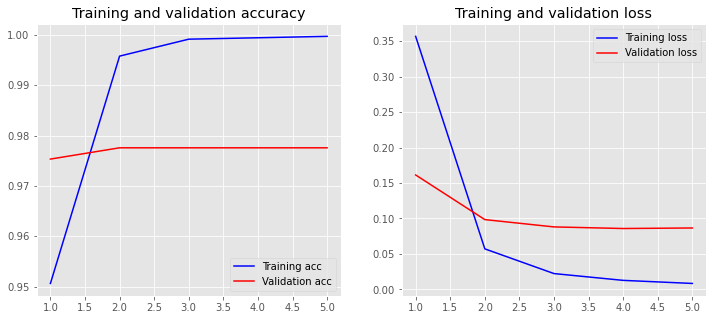

In [26]:
acc_loss(nn_it)

# Notes:
* Even though we set 50 epochs, early stopping stopped at 5 epochs. 
* Overfitting happens when the validation loss curve (red on the right) starts rising. Hence we are not overfitting.
* This was one of the simplest NN possible which explains why there is such a huge difference between training and validations accuracy/loss.

# Word Embedding
* Word embeddings are basically a form of word representation that bridges the human understanding of language to that of a machine. Word embeddings are distributed representations of text in an n-dimensional space. These are essential for solving most NLP problems.
* Word2Vec one of the most used forms of word embedding is described by Wikipedia as: “Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located in close proximity to one another in the space.”
* In our case, we will not use pre-trained model like Word2vec or Glove because these are huge files (~ 1GB for Glove).
* Instead, we will make OUR dictionnary

## Parameters to set:

In [27]:
num_words = 1000
maxlen = 150
embedding_dim = 50

In [28]:
tokenizer = Tokenizer(num_words=num_words,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', # Removing special characters as well as punctuation
                      lower=True,                                     # Keep the distinct. bc it is important in Spam detection
                      split=' ',                                      # "Words are set of char splitted by a space"
                      char_level=False)                               # If True, every character will be treated as a token
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print("Original sentence: {} ".format(sentences_train[1]) )
print("Tokenized sentence: {} ".format(X_train[1]))

Original sentence: Are you willing to go for apps class. 
Tokenized sentence: [22, 3, 2, 45, 12, 296] 


### Process the data
* **Note**: Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.
* With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

In [29]:
for word in ['hi', 'hi', 'hello', 'there']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

hi: 100
hi: 100
hello: 250
there: 70


### Padding
* One problem that we have is that each text sequence has in most cases different length of words. To counter this, you can use pad_sequence() which simply pads the sequence of words with zeros.

In [30]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

count = 0
for i in X_train:
    if len(X_train[i]) == maxlen:
        count = count + 1 
    else:
        count = count
if count == len(X_train):
    print("Padding worked fine")
else: print("Problem with padding")

Padding worked fine


In [31]:
def def_flat_NN():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = vocab_size, 
                      output_dim = embedding_dim, 
                      input_length = maxlen)(inputs)
    layer = Flatten()(layer)
    layer = Dense(10, activation = 'relu')(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_flat_NN()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           397950    
_________________________________________________________________
flatten_1 (Flatten)          (None, 7500)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                75010     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 472,971
Trainable params: 472,971
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
nn_it = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=0,
                    validation_split = 0.2,
                    batch_size=128,
                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.000001), TQDMNotebookCallback()])

model.save('h5df/model.WE')


Wall time: 2.6 s


In [33]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9906
Testing Accuracy:  0.9758


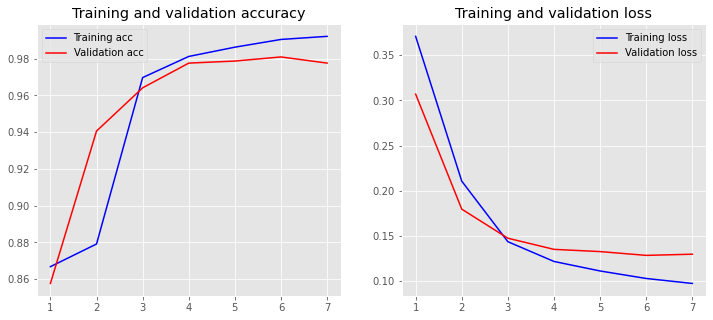

In [34]:
acc_loss(nn_it)

# Notes:
* We can clearly see that our validation accuracy follows perfectly the training accuracy until 0.96%.
* Loss plot shows that we are not overfitting.

# Let's instantiate a LSTM - Long-Short-Term-Memory Model
* LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series. LSTMs were developed to deal with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs. Relative insensitivity to gap length is an advantage of LSTM over RNNs, hidden Markov models and other sequence learning methods in numerous applications.
* A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

## Parameters to set:

In [35]:
num_words = 1000
maxlen = 150
embedding_dim = 50

In [36]:
def def_LSTM():
    inputs = Input(name='inputs', shape=[maxlen])
    layer = Embedding(input_dim = num_words, output_dim = embedding_dim, input_length = maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1)(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

model = def_LSTM()
model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
              loss='binary_crossentropy',  # Binary Classification SPAM/HAM
              metrics=['accuracy'])        # Metrics we want to maximize
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_5 (Dense)              (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257 

In [37]:
%%time
nn_it = model.fit(X_train, y_train,
          epochs=10,
          verbose=0,
          validation_split = 0.2,
          batch_size=128,
          callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), TQDMNotebookCallback()])

model.save('h5df/model.WE_LSTM')


Wall time: 21.4 s


In [38]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9930
Testing Accuracy:  0.9830


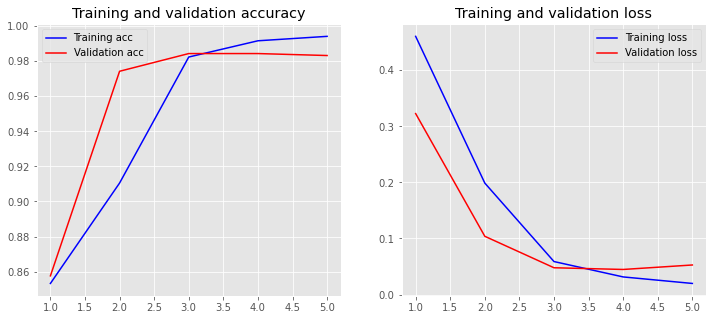

In [39]:
acc_loss(nn_it)

# Notes:
* Surprised that our validation accuracy is better than our training accuracy until the third epoch.
* Loss plot shows that we are not overfitting until the third epoch. Indeed, from the third epoch validation loss starts to rise.

In [ ]:
#### How to calculate optimal batch size ?
Minibatch sizes are generally driven by the following factors:

* **Larger batches provide a more accurate estimate of the gradient**, but with less than linear returns.
* Multicore architectures are usually underutilized by extremely small batches. This motivates using some**absolute minimum batch size**, below which there is no reduction in the time to process a minibatch.
* If all examples in the batch are to be processed in parallel (as is typically thecase), then the amount of memory scales with the batch size. For many hardware setups this is the limiting factor in batch size.
* Some kinds of hardware achieve better runtime with speciﬁc sizes of arrays. Especially when using GPUs, it is common for power of 2 batch sizes to offer better runtime. **Typical power of 2 batch sizes range from 32 to 256, with 16 sometimes being attempted for large models**.
* **Small batches can offer a regularizing effect** (Wilson and Martinez, 2003), perhaps due to **the noise they add** to the learning process. **Generalization error is often best for a batch size of 1**. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.  

#### Conclusion:
* Estimation of the gradient is better with larger batch sizes.
* Depends if you are running on GPU or CPU (in our case CPU). If so, specific sizes of arrays (power of 2) offers better runtime.
* Small batches add noise to the learning process. Generalization error is often best for **batch_size = 1**.

# Hyperparameter Optimization through Keras
Even though there are several ways in order to optimize hyperparameters (Manual, Machine-Assisted, Algorithmic), we will focus on the Machine-Assisted.
In Keras there are different methods: TensorBoard GridSearch RandomizedSearch and so on...  
In our case we will use [TensorBoard](https://www.tensorflow.org/tensorboard). 

In order to have access to TensorBoard, do not forget to ```pip3 install tensorboard``` in the cmd prompt.  

The first step is to define the space of hyper-parameters we want to go through:

```python
dense_layers = [1]
LSTM_sizes = [16, 32, 64, 128]
Dense_sizes = [64, 128, 256]
dropout = [0.1, 0.2, 0.5]
batch_sizes = [32, 64, 128]
```

We then loop over each list in order to create all possible pairs:
``` python
for dense_layer in dense_layers:
    for LSTM_size in LSTM_sizes:
        for Dense_size in Dense_sizes:
            for drop in dropout:
                for batch_size in batch_sizes:
```

In order to recognize what model is in the log, we define a **NAME** variable that will define what model we are currently training.  
The last step is just to introduce the TensorBoard: 
```python 
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))
```

In [ ]:
%%time

dense_layers = [1]
LSTM_sizes = [16, 32, 64, 128]
Dense_sizes = [64, 128, 256]
dropout = [0.1, 0.2, 0.5]
batch_sizes = [32, 64, 128]

for dense_layer in dense_layers:
    for LSTM_size in LSTM_sizes:
        for Dense_size in Dense_sizes:
            for drop in dropout:
                for batch_size in batch_sizes:

                    NAME = "{}-nodes_LSTM-{}-nodes_Dense-{}-Dropout-{}-batch_size".format(LSTM_size, Dense_size, drop, batch_size)
                    tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))
                    print(NAME)

                    model = Sequential()

                    for l in range(dense_layer):
                        model.add(Embedding(input_dim = num_words,
                                            output_dim = embedding_dim,
                                            input_length = maxlen))
                        model.add(LSTM(LSTM_size))
                        model.add(Dense(Dense_size))
                        model.add(Activation('relu'))
                        model.add(Dropout(drop))
                        model.add(Dense(1))
                        model.add(Activation('sigmoid'))

                        model.compile(optimizer='adam',            # Adam optimization algorithm is an extension to stochastic gradient
                                      loss='binary_crossentropy',  # Binary Classification SPAM/HAM
                                      metrics=['accuracy'])        # Metrics we want to maximize

                        model.fit(X_train, y_train,
                                      validation_data=(X_test, y_test), batch_size = batch_size,
                                      epochs = 100,
                                      callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), tensorboard, TQDMNotebookCallback()],
                                      shuffle = True,
                                      verbose = 0)

16-nodes_LSTM-64-nodes_Dense-0.1-Dropout-32-batch_size





16-nodes_LSTM-64-nodes_Dense-0.1-Dropout-64-batch_size



16-nodes_LSTM-64-nodes_Dense-0.1-Dropout-128-batch_size



16-nodes_LSTM-64-nodes_Dense-0.2-Dropout-32-batch_size



16-nodes_LSTM-64-nodes_Dense-0.2-Dropout-64-batch_size



16-nodes_LSTM-64-nodes_Dense-0.2-Dropout-128-batch_size



16-nodes_LSTM-64-nodes_Dense-0.5-Dropout-32-batch_size



16-nodes_LSTM-64-nodes_Dense-0.5-Dropout-64-batch_size



16-nodes_LSTM-64-nodes_Dense-0.5-Dropout-128-batch_size



16-nodes_LSTM-128-nodes_Dense-0.1-Dropout-32-batch_size



16-nodes_LSTM-128-nodes_Dense-0.1-Dropout-64-batch_size



16-nodes_LSTM-128-nodes_Dense-0.1-Dropout-128-batch_size



16-nodes_LSTM-128-nodes_Dense-0.2-Dropout-32-batch_size



16-nodes_LSTM-128-nodes_Dense-0.2-Dropout-64-batch_size



16-nodes_LSTM-128-nodes_Dense-0.2-Dropout-128-batch_size



16-nodes_LSTM-128-nodes_Dense-0.5-Dropout-32-batch_size



16-nodes_LSTM-128-nodes_Dense-0.5-Dropout-64-batch_size



16-nodes_LSTM-128-nodes_Dense-0.5-Dropout-128-batch_size



16-nodes_LSTM-256-nodes_Dense-0.1-Dropout-32-batch_size



16-nodes_LSTM-256-nodes_Dense-0.1-Dropout-64-batch_size



16-nodes_LSTM-256-nodes_Dense-0.1-Dropout-128-batch_size



16-nodes_LSTM-256-nodes_Dense-0.2-Dropout-32-batch_size



16-nodes_LSTM-256-nodes_Dense-0.2-Dropout-64-batch_size



16-nodes_LSTM-256-nodes_Dense-0.2-Dropout-128-batch_size



16-nodes_LSTM-256-nodes_Dense-0.5-Dropout-32-batch_size



16-nodes_LSTM-256-nodes_Dense-0.5-Dropout-64-batch_size



16-nodes_LSTM-256-nodes_Dense-0.5-Dropout-128-batch_size



32-nodes_LSTM-64-nodes_Dense-0.1-Dropout-32-batch_size



32-nodes_LSTM-64-nodes_Dense-0.1-Dropout-64-batch_size



32-nodes_LSTM-64-nodes_Dense-0.1-Dropout-128-batch_size



32-nodes_LSTM-64-nodes_Dense-0.2-Dropout-32-batch_size



32-nodes_LSTM-64-nodes_Dense-0.2-Dropout-64-batch_size



32-nodes_LSTM-64-nodes_Dense-0.2-Dropout-128-batch_size



32-nodes_LSTM-64-nodes_Dense-0.5-Dropout-32-batch_size



32-nodes_LSTM-64-nodes_Dense-0.5-Dropout-64-batch_size



32-nodes_LSTM-64-nodes_Dense-0.5-Dropout-128-batch_size



32-nodes_LSTM-128-nodes_Dense-0.1-Dropout-32-batch_size



32-nodes_LSTM-128-nodes_Dense-0.1-Dropout-64-batch_size



32-nodes_LSTM-128-nodes_Dense-0.1-Dropout-128-batch_size



32-nodes_LSTM-128-nodes_Dense-0.2-Dropout-32-batch_size



32-nodes_LSTM-128-nodes_Dense-0.2-Dropout-64-batch_size



32-nodes_LSTM-128-nodes_Dense-0.2-Dropout-128-batch_size



32-nodes_LSTM-128-nodes_Dense-0.5-Dropout-32-batch_size



32-nodes_LSTM-128-nodes_Dense-0.5-Dropout-64-batch_size



32-nodes_LSTM-128-nodes_Dense-0.5-Dropout-128-batch_size



32-nodes_LSTM-256-nodes_Dense-0.1-Dropout-32-batch_size



32-nodes_LSTM-256-nodes_Dense-0.1-Dropout-64-batch_size



32-nodes_LSTM-256-nodes_Dense-0.1-Dropout-128-batch_size



32-nodes_LSTM-256-nodes_Dense-0.2-Dropout-32-batch_size



32-nodes_LSTM-256-nodes_Dense-0.2-Dropout-64-batch_size



32-nodes_LSTM-256-nodes_Dense-0.2-Dropout-128-batch_size



32-nodes_LSTM-256-nodes_Dense-0.5-Dropout-32-batch_size



32-nodes_LSTM-256-nodes_Dense-0.5-Dropout-64-batch_size



32-nodes_LSTM-256-nodes_Dense-0.5-Dropout-128-batch_size



64-nodes_LSTM-64-nodes_Dense-0.1-Dropout-32-batch_size



64-nodes_LSTM-64-nodes_Dense-0.1-Dropout-64-batch_size



64-nodes_LSTM-64-nodes_Dense-0.1-Dropout-128-batch_size



64-nodes_LSTM-64-nodes_Dense-0.2-Dropout-32-batch_size



64-nodes_LSTM-64-nodes_Dense-0.2-Dropout-64-batch_size



64-nodes_LSTM-64-nodes_Dense-0.2-Dropout-128-batch_size



64-nodes_LSTM-64-nodes_Dense-0.5-Dropout-32-batch_size



64-nodes_LSTM-64-nodes_Dense-0.5-Dropout-64-batch_size



64-nodes_LSTM-64-nodes_Dense-0.5-Dropout-128-batch_size



64-nodes_LSTM-128-nodes_Dense-0.1-Dropout-32-batch_size



64-nodes_LSTM-128-nodes_Dense-0.1-Dropout-64-batch_size



64-nodes_LSTM-128-nodes_Dense-0.1-Dropout-128-batch_size



64-nodes_LSTM-128-nodes_Dense-0.2-Dropout-32-batch_size



64-nodes_LSTM-128-nodes_Dense-0.2-Dropout-64-batch_size



64-nodes_LSTM-128-nodes_Dense-0.2-Dropout-128-batch_size



64-nodes_LSTM-128-nodes_Dense-0.5-Dropout-32-batch_size



64-nodes_LSTM-128-nodes_Dense-0.5-Dropout-64-batch_size



64-nodes_LSTM-128-nodes_Dense-0.5-Dropout-128-batch_size



64-nodes_LSTM-256-nodes_Dense-0.1-Dropout-32-batch_size



64-nodes_LSTM-256-nodes_Dense-0.1-Dropout-64-batch_size



64-nodes_LSTM-256-nodes_Dense-0.1-Dropout-128-batch_size



64-nodes_LSTM-256-nodes_Dense-0.2-Dropout-32-batch_size



64-nodes_LSTM-256-nodes_Dense-0.2-Dropout-64-batch_size



64-nodes_LSTM-256-nodes_Dense-0.2-Dropout-128-batch_size



64-nodes_LSTM-256-nodes_Dense-0.5-Dropout-32-batch_size



64-nodes_LSTM-256-nodes_Dense-0.5-Dropout-64-batch_size



64-nodes_LSTM-256-nodes_Dense-0.5-Dropout-128-batch_size



128-nodes_LSTM-64-nodes_Dense-0.1-Dropout-32-batch_size



128-nodes_LSTM-64-nodes_Dense-0.1-Dropout-64-batch_size



128-nodes_LSTM-64-nodes_Dense-0.1-Dropout-128-batch_size


What we have now is a ```logs``` directory. In order to read those results into TensorBoard, simply write the following command in your ```cmd```:  
```tensorboard --logdir=path\to\logs --host localhost --port 8088```  
Open a web browser and as the URL put:  
```http://localhost:8088/```

# Here are our results

Hyperparameter took a long time to run: x minutes
[![Image from Gyazo](https://i.gyazo.com/4a6b6b9274f7998c1754c81ea1eda8a8.png)](https://gyazo.com/4a6b6b9274f7998c1754c81ea1eda8a8)

[![Image from Gyazo](https://i.gyazo.com/1c8ffa7ff36f0f609fab3a73bf66b61b.gif)](https://gyazo.com/1c8ffa7ff36f0f609fab3a73bf66b61b)

According to our results (cf. picture below) the best model (i.e. the one with the least validation loss is a  16 Nodes LSTM with 128 neurons on the second hidden layer with a Dropout of 0.1.

[![Image from Gyazo](https://i.gyazo.com/5ff23efc280882d619811aeda8db6461.png)](https://gyazo.com/5ff23efc280882d619811aeda8db6461)